In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transforms3d as t3d
import itertools
from tqdm import tqdm

## good optimizers:
https://nlopt.readthedocs.io/en/latest/
pagmo / pygmo

mystic might be the best: https://github.com/uqfoundation/mystic 
http://trac.mystic.cacr.caltech.edu/project/mystic/wiki.html

## define helper functions

In [2]:
from sklearn.metrics import mean_squared_error

def convert_quat_and_cart_to_homogeneous(q, xyz):
    T = np.eye(4)
    T[:3,:3] = t3d.quaternions.quat2mat(q) #w,x,y,z
    T[:3,3] = xyz
    return T

def generate_random_homogeneous_transform():
    q = np.random.dirichlet([1.3, 1.3, 1.3, 1.3], size = 1).squeeze()
    xyz = np.random.rand(3)
    return convert_quat_and_cart_to_homogeneous(q, xyz)

def list_permuter(list1, list2):
    #subitem for item in a for subitem in (item if isinstance(item, list) else [item])
    return [[subitem for item in pair for subitem in (item if isinstance(item, list) else [item])] for
            pair in itertools.product(list1,list2)]



## make a synthetic point set and plot it

In [3]:
#define all the points of the object
alpha = 0.05
point_positions = np.array([[1, -1, 0],[-1, -1, 0], [-1, 1, 0],[1, 0, -1],[-np.cos(np.pi/3), -np.sin(np.pi/3), -1],
                            [-np.cos(np.pi/3), np.sin(np.pi/3), -1]]).T

point_positions[2,:] *= -1

point_positions = point_positions * 25.4
point_positions_noisy = point_positions + np.random.normal(loc=0.0, scale=alpha, size = point_positions.shape)

In [4]:
point_positions.shape

(3, 6)

<IPython.core.display.Javascript object>


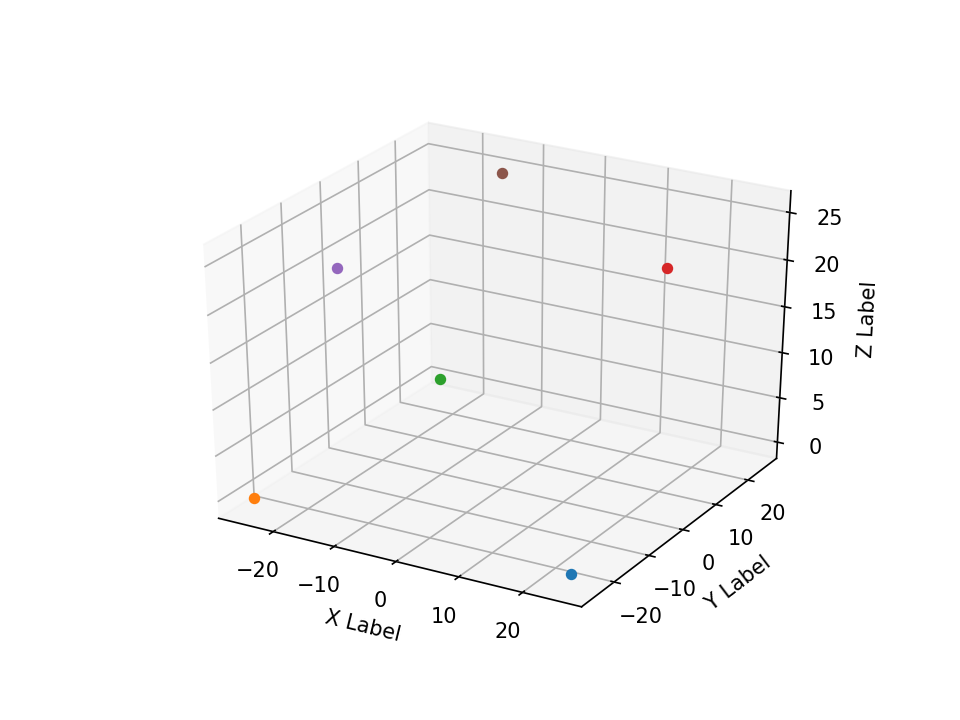

[-12.7        -21.99704526  25.4       ]


In [5]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(6):
    ax.scatter(point_positions[0,i], point_positions[1,i], point_positions[2,i])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

print(point_positions[:,4])

## compare to actual points

<IPython.core.display.Javascript object>


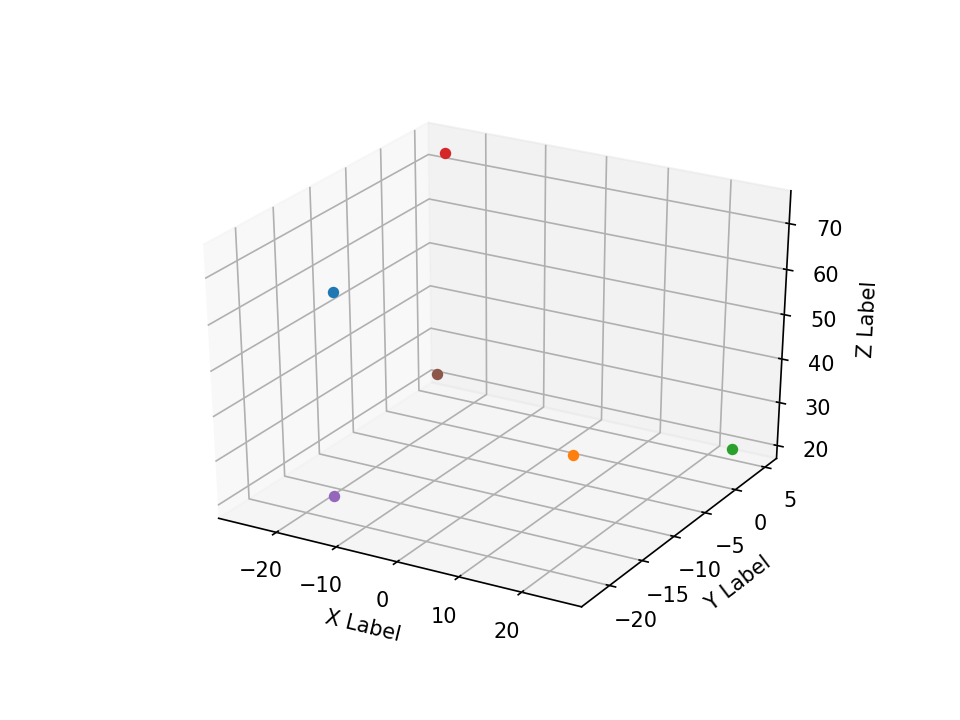

[-12.7        -21.99704526  25.4          1.        ]


In [6]:
centroids = np.load('centroids.npy')
centroids = np.vstack([centroids.T, np.ones(6)])

diff = centroids[:3,4] - point_positions[:,4]
centroids[:3,:] = centroids[:3,:] - diff[:,None]
#point_positions_noisy_transformed = np.array([centroids[0,:], centroids[1,:], -centroids[2,:], centroids[3,:]])
#point_positions_noisy_transformed = np.array([centroids[1,:], centroids[2,:], centroids[0,:], centroids[3,:]])
#point_positions_noisy_transformed = np.array([centroids[1,:], centroids[2,:], centroids[0,:], centroids[3,:]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(6):
    ax.scatter(centroids[0,i], centroids[1,i], centroids[2,i])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

print(centroids[:,4])

## guess the transform

<IPython.core.display.Javascript object>


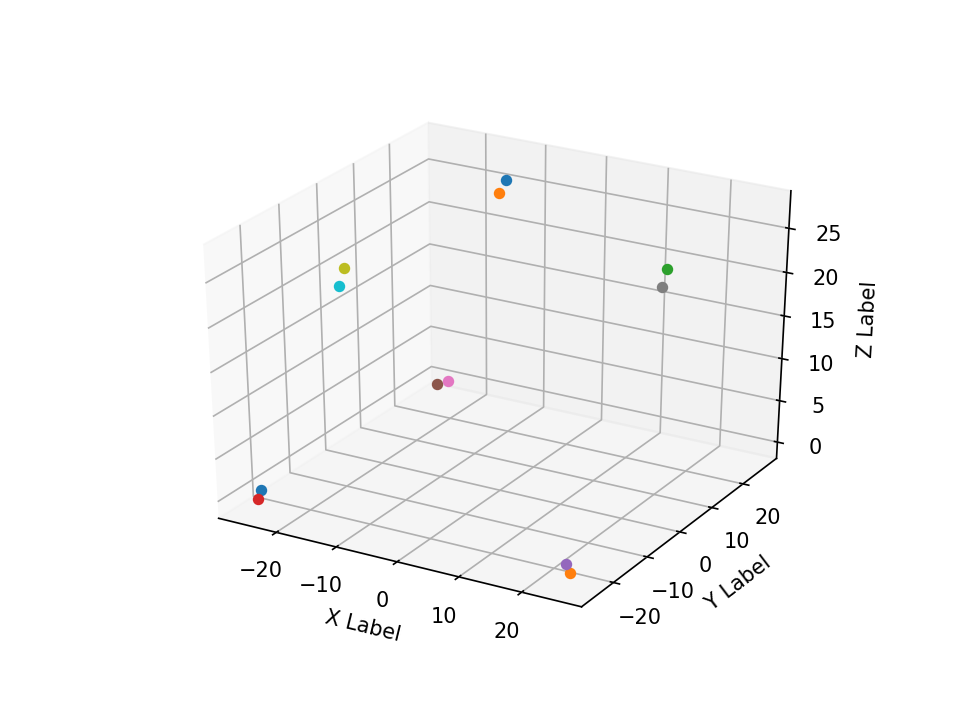

[-12.7        -21.99704526  25.4          1.        ]
8.941390582678407
[[ 1.000000e+00 -0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17  1.000000e+00]
 [-0.000000e+00 -1.000000e+00  6.123234e-17]]


In [7]:
#guess the transform: positive 90 around the x axis

T_guess = t3d.euler.euler2mat(-np.pi/2, 0, 0) #i,j,k: x,y,z

centroids = np.load('centroids.npy')
centroids = np.vstack([centroids.T, np.ones(6)])

diff = centroids[:3,4] - point_positions[:,4]
centroids[:3,:] = centroids[:3,:] - diff[:,None]
#point_positions_noisy_transformed = np.array([centroids[0,:], centroids[1,:], -centroids[2,:], centroids[3,:]])
#point_positions_noisy_transformed = np.array([centroids[1,:], centroids[2,:], centroids[0,:], centroids[3,:]])
#point_positions_noisy_transformed = np.array([centroids[1,:], centroids[2,:], centroids[0,:], centroids[3,:]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mse = 0
for i in range(6):
    temp = T_guess @ centroids[:3,i] + np.array([0,-46,5])
    mse = ((temp - point_positions[:,i])**2).sum()**0.5/6
    ax.scatter(temp[0], temp[1], temp[2])
    ax.scatter(point_positions[0,i], point_positions[1,i], point_positions[2,i])


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

print(centroids[:,4])
print(mse)
print(T_guess)

## solve for transform

In [8]:
T_random = generate_random_homogeneous_transform()

point_positions_SE3 = np.vstack([point_positions, np.ones(6)])
point_positions_noisy = centroids#np.vstack([point_positions_noisy, np.ones(6)])
point_positions_noisy = T_random @ centroids
#point_positions_noisy_transformed = T @ point_positions_noisy
point_permutations = np.array(list(itertools.permutations(list(range(6)), 6)))

In [9]:
from scipy.optimize import minimize

# generate quaternion and xyz translation vector
# constraints: ||q|| = 1, |xyz| < 10
# loss: loss(point_positions, convert_quat_and_cart_to_homogeneous(q,xyz)@point_positions_noisy)
def objective(quat_xyz, point_positions, observed_point_positions):
    #returns MSE between points
    q = quat_xyz[0:4]
    xyz = quat_xyz[4:]
    T = convert_quat_and_cart_to_homogeneous(q,xyz)
    return mean_squared_error(T@point_positions, observed_point_positions)

def eq_constraint(quat_xyz):
    return np.sum(quat_xyz[:4]**2)**0.5 - 1 #POSSIBLE ERROR

results = []
error = []
for i in tqdm(range(point_permutations.shape[0])):
    result = minimize(objective, x0 = np.array([1,0,0,0,0,0,0]), args=(point_positions_SE3, point_positions_noisy[:,point_permutations[i,:]]), method = 'SLSQP', constraints={"fun": eq_constraint, "type": "eq"})
    #print(result)
    results.append(result)
    error.append(result['fun'])
error = np.array(error)



100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [00:41<00:00, 24.12it/s]


In [10]:
plt.rcParams['figure.figsize'] = [15, 5]

min_error = np.amin(error)
min_error_index = np.argmin(error)
max_error = np.amax(error)
max_error_index = np.argmax(error)

quat_xyz = results[min_error_index]['x']
T = convert_quat_and_cart_to_homogeneous(quat_xyz[:4], quat_xyz[4:])

quat_xyz_worst = results[max_error_index]['x']
T_worst = convert_quat_and_cart_to_homogeneous(quat_xyz_worst[:4], quat_xyz_worst[4:])

'''
plt.figure()
plt.subplot(1,3,1)
plt.scatter(point_positions_noisy_transformed[0,:], point_positions_noisy_transformed[2,:])
plt.scatter((T@point_positions)[0,:], (T@point_positions)[2,:])
plt.legend(['Observed', 'Reprojected'])
plt.title('Best transform')

plt.subplot(1,3,2)
plt.scatter(point_positions_noisy_transformed[0,:], point_positions_noisy_transformed[2,:])
plt.scatter((T_worst@point_positions)[0,:], (T_worst@point_positions)[2,:])
plt.legend(['Observed', 'Reprojected'])
plt.title('Worst transform')

plt.subplot(1,3,3)
plt.plot(error)
plt.title('Error (MSE)')
plt.scatter([min_error_index], [min_error])
plt.scatter([max_error_index], [max_error])
plt.legend(['Error plot','Min error', 'Max error'])
plt.savefig('image_alignment_test.png', bbox_inches='tight')

plt.show()
'''

print(T)


[[-3.44202648e-01  8.70068069e-01  3.52854208e-01  4.01486779e+01]
 [ 5.74160382e-01  4.92415375e-01 -6.54115399e-01  2.59289247e+01]
 [-7.42875759e-01 -2.25533454e-02 -6.69049291e-01  2.65571344e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<IPython.core.display.Javascript object>


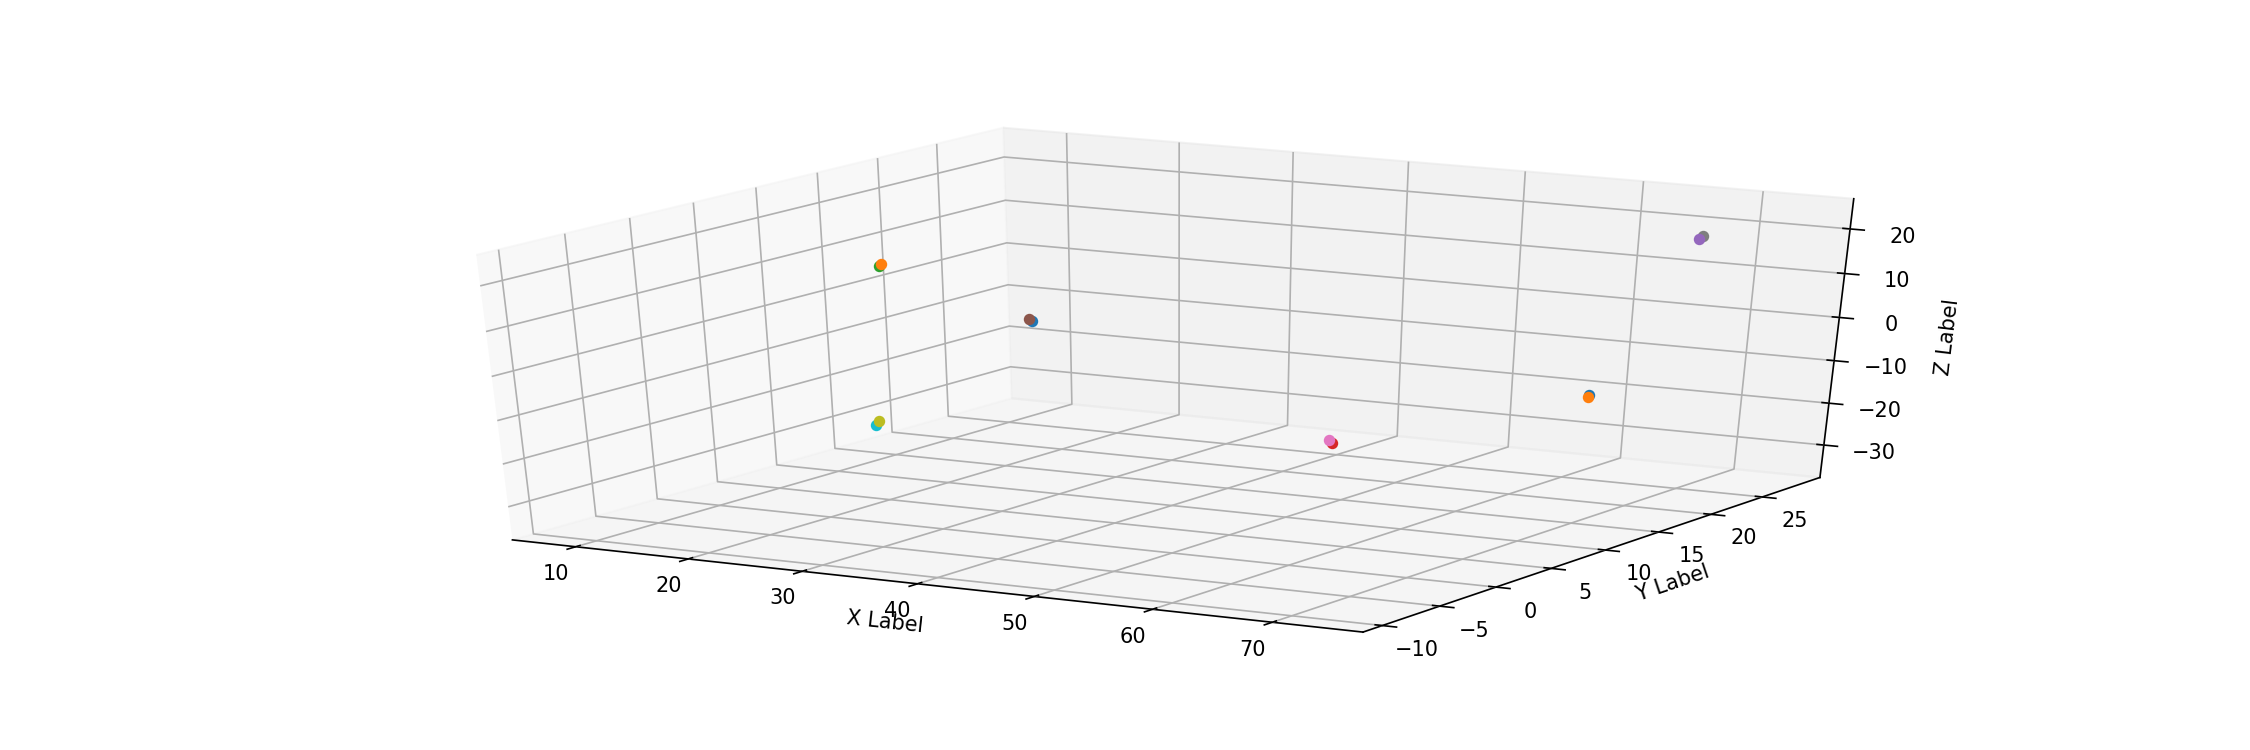

[-12.7        -21.99704526  25.4          1.        ]
9.242036827931399
[[ 1.000000e+00 -0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17  1.000000e+00]
 [-0.000000e+00 -1.000000e+00  6.123234e-17]]


In [11]:
#guess the transform: positive 90 around the x axis

#T_guess = t3d.euler.euler2mat(-np.pi/2, 0, 0) #i,j,k: x,y,z

#centroids = np.load('centroids.npy')
#centroids = np.vstack([centroids.T, np.ones(6)])

#diff = centroids[:3,4] - point_positions[:,4]
#centroids[:3,:] = centroids[:3,:] - diff[:,None]
#point_positions_noisy_transformed = np.array([centroids[0,:], centroids[1,:], -centroids[2,:], centroids[3,:]])
#point_positions_noisy_transformed = np.array([centroids[1,:], centroids[2,:], centroids[0,:], centroids[3,:]])
#point_positions_noisy_transformed = np.array([centroids[1,:], centroids[2,:], centroids[0,:], centroids[3,:]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mse = 0
for i in range(6):
    #temp = T[:3,:3] @ centroids[:3,i] + T[:3,3]
    #mse = ((temp - point_positions[:,i])**2).sum()**0.5/6
    temp = T[:3,:3] @ point_positions[:3,i] + T[:3,3]
    mse = ((temp - point_positions_noisy[:3,i])**2).sum()**0.5/6
    
    ax.scatter(temp[0], temp[1], temp[2])
    ax.scatter(point_positions_noisy[0,i], point_positions_noisy[1,i], point_positions_noisy[2,i])


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

print(mse)